In [1]:
%load_ext autoreload

%autoreload 2

import os
from glob import glob
import subprocess
import shutil
import traceback
import random
import pickle
from os.path import join

import joblib
from concurrent.futures import ProcessPoolExecutor

from backports import tempfile

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
matplotlib.rcParams["image.composite_image"]=False
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.linalg
from numpy.fft import rfft, irfft, fft, ifft

import multiprocessing
import concurrent.futures

import psrchive
import residuals

import pipe
from pipe import rotate_phase, convert_template, align_profile, align_scale_profile

import template_match as tm

plt.viridis()

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


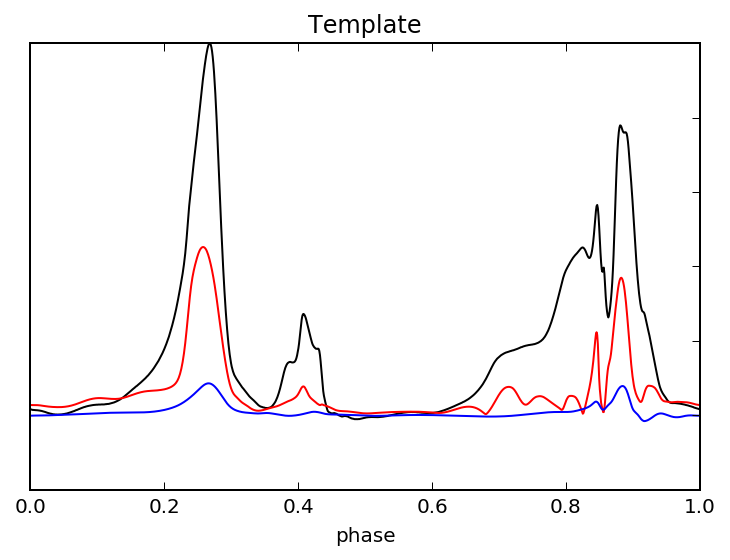

In [2]:
template = "template-work/56412.76_GBT_1400.rmset.scrunch.sm"
T = psrchive.Archive_load(template)
T.convert_state('Stokes')
T.dedisperse()
T.remove_baseline()
t_values = T.get_data()[0,0,0,:]
t_pol = T.get_data()[0,:,0,:]
t_pol /= np.amax(t_values)
t_values /= np.amax(t_values)
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t_values)[1])/(2*np.pi)
t_values = pipe.rotate_phase(t_values, -a) 
t_pol = np.array([pipe.rotate_phase(p, -a) for p in t_pol])
t_phases = np.linspace(0,1,len(t_values),endpoint=False)
np.save("template-iquv.npy", t_pol)
plt.plot(t_phases,t_pol[0],color='k')
plt.plot(t_phases,np.hypot(t_pol[1],t_pol[2]),color='r')
plt.plot(t_phases,t_pol[3],color='b')
plt.title("Template")
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")

## Initial demos

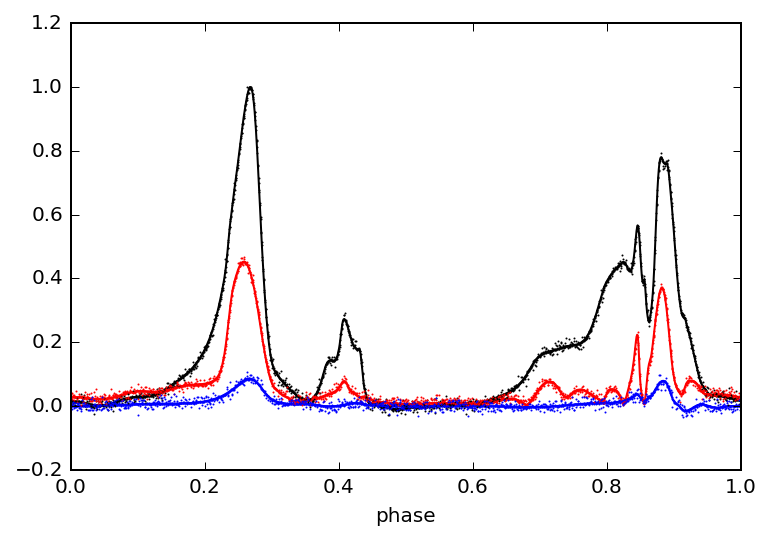

In [66]:
noise_per_bin = 1e-2
t_fake = t_pol + noise_per_bin*np.random.randn(*t_pol.shape)
markersize=2
tm.plot_iquv(t_pol,linestyle="-")
tm.plot_iquv(t_fake)


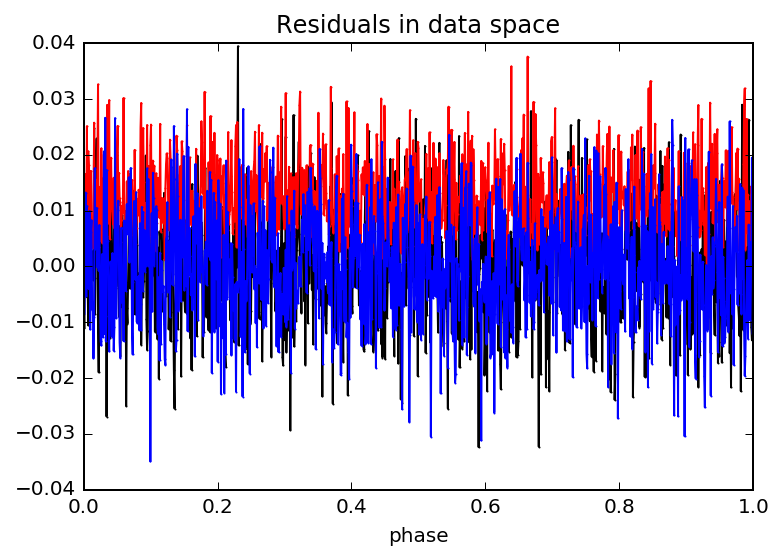

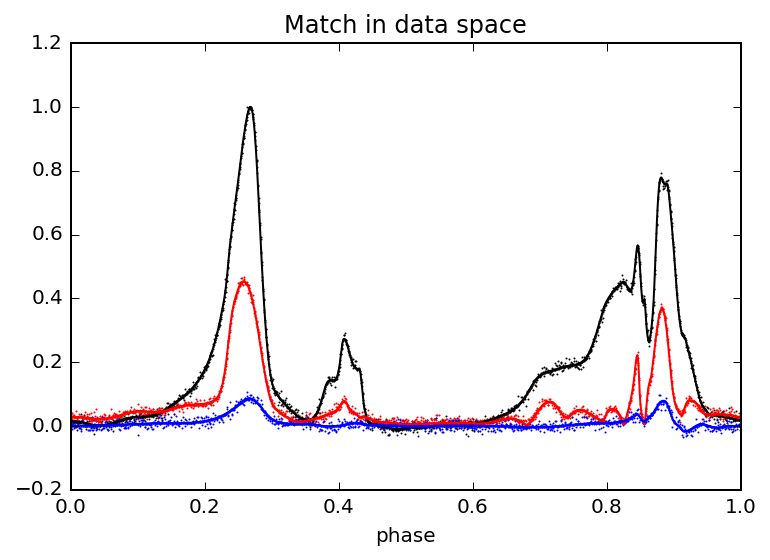

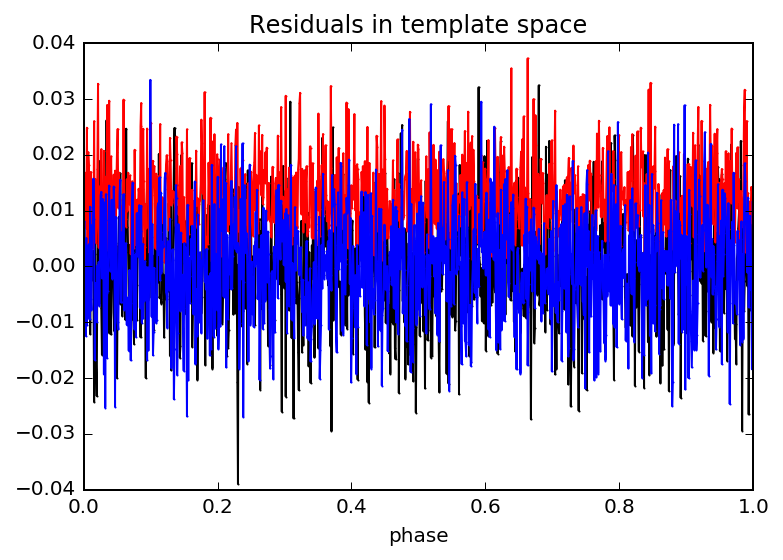

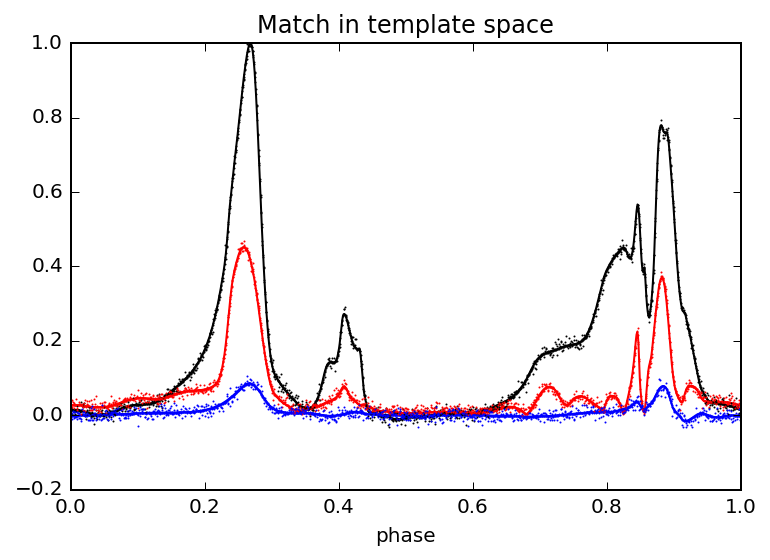

In [69]:
r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)

tm.plot_iquv(r.residuals, linestyle="-")
plt.title("Residuals in data space")

plt.figure()
tm.plot_iquv(t_fake)
tm.plot_iquv(r.template_in_data_space, linestyle="-")
plt.title("Match in data space")

plt.figure()
tm.plot_iquv(r.residuals_template, linestyle="-")
plt.title("Residuals in template space")

plt.figure()
tm.plot_iquv(t_pol, linestyle="-")
tm.plot_iquv(r.data_in_template_space)
plt.title("Match in template space")



What about polarization transformations?

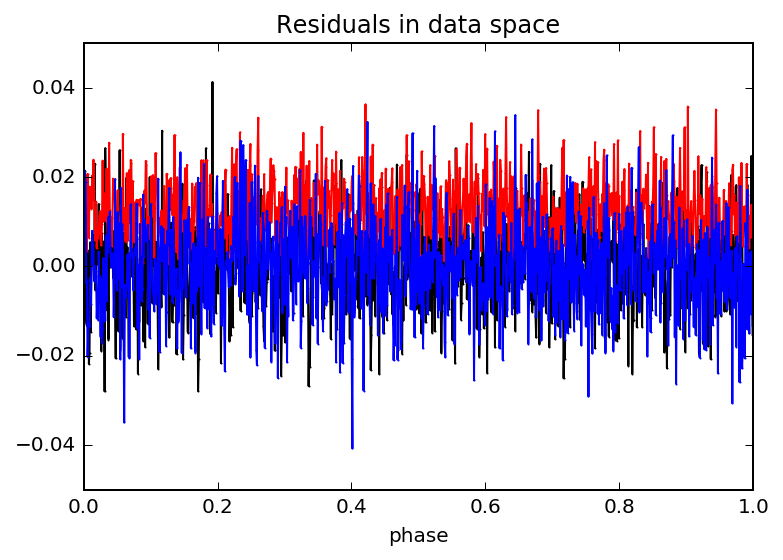

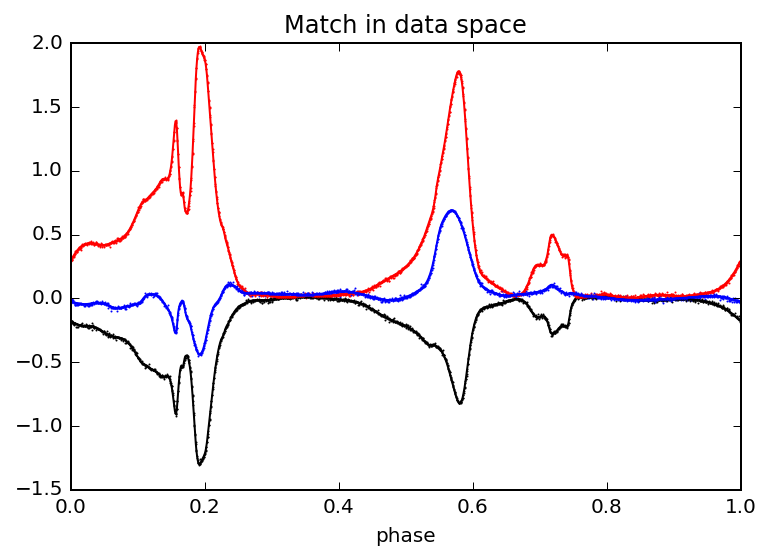

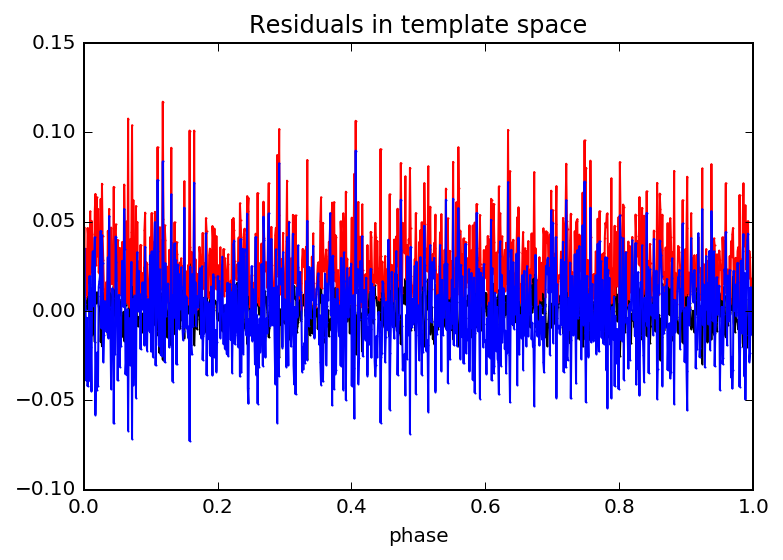

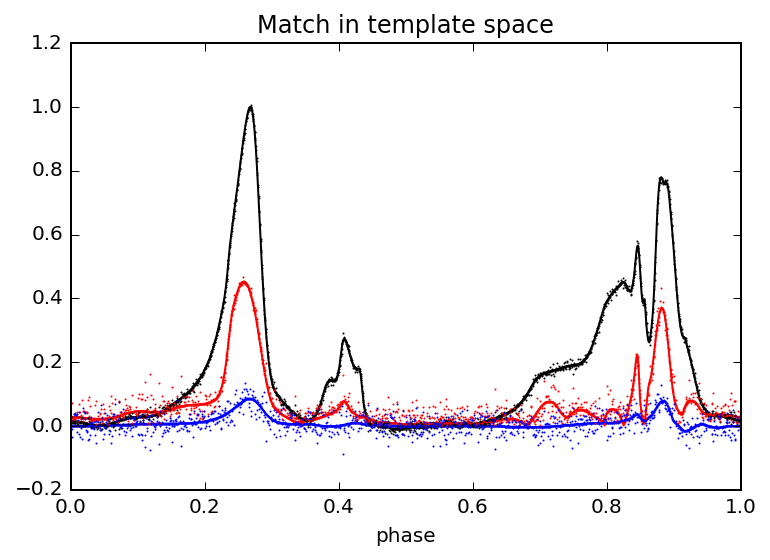

In [71]:
M = np.random.randn(4,4) # Whee!
shift = np.random.random()
t_fake = np.dot(M, tm.rotate_phase_iquv(t_pol, shift)) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])

r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)

tm.plot_iquv(r.residuals, linestyle="-")
plt.title("Residuals in data space")

plt.figure()
tm.plot_iquv(t_fake)
tm.plot_iquv(r.template_in_data_space, linestyle="-")
plt.title("Match in data space")

plt.figure()
tm.plot_iquv(r.residuals_template, linestyle="-")
plt.title("Residuals in template space")

plt.figure()
tm.plot_iquv(t_pol, linestyle="-")
tm.plot_iquv(r.data_in_template_space)
plt.title("Match in template space")



### Checking the global search

In [110]:
for i in range(9,100):
    np.random.seed(i)
    print i
    M = np.random.randn(4,4) # Whee!
    shift = np.random.random()
    t_fake = np.dot(M, tm.rotate_phase_iquv(t_pol, shift)) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])

    r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)


9
214.762740475 214.076475102 222.864322402
0.427235980927 0.429099874579 0.502191109904


ValueError: Not a bracketing interval.

In [113]:

f_t = rfft(t_pol)
# The real components mess up the L2 preservation somehow
f_t[:,0] = 0 # want to ignore constants
f_t[:,-1] /= np.sqrt(2)
np.sum(np.abs(f_t)**2,axis=1)/np.sum((t_pol-t_pol.mean(axis=1)[:,None])**2,axis=1)

array([ 512.,  512.,  512.,  512.])

In [106]:
# Check that rotate_phase does something invertible with the Nyquist coefficient
# Presumably that is, leave it unchanged
shift = 0.3
np.amax(np.abs(tm.rotate_phase_iquv(tm.rotate_phase_iquv(t_fake, shift), -shift) - t_fake))
                                    

4.4408920985006262e-16

In [146]:
phases = np.linspace(0,0.5,5,endpoint=False)[:1]
def qof(template, data, phase):
    t_shift = tm.rotate_phase_iquv(template,phase)
    t_fit, M, c = tm.fit_mueller(data, t_shift)
    print M
    return np.sum((data-t_fit)**2)
def pack_complex(a):
    p, n = a.shape
    r = np.zeros((p,2*n))
    r[:,::2] = a.real
    r[:,1::2] = a.imag
    return r
def unpack_complex(a):
    p, n = a.shape
    r = np.zeros((p,n//2),dtype=complex)
    r.real = a[:,::2]
    r.imag = a[:,1::2]
    return r
    
def qof_f(template, data, phase):
    t_f = rfft(template)
    d_f = rfft(data)
    #t_f[:,0] = d_f[:,0] = 0
    t_f[:,-1] /= np.sqrt(2)
    d_f[:,-1] /= np.sqrt(2)
    t_f[:,1:-1] *= np.exp(2.j*np.pi*phase*np.arange(1,t_f.shape[1]-1)[None,:])
    t_fit_f, M, c = tm.fit_mueller(pack_complex(d_f), 
                                   pack_complex(t_f), 
                                   const=False)
    t_fit_f = unpack_complex(t_fit_f)
    print M
    #return np.sum(np.abs(t_fit_f-d_f)**2)
    res_f = d_f-t_fit_f
    res_f[:,0] = 0
    res_f[:,-1] *= np.sqrt(2)
    return np.sum(irfft(res_f)**2)

a1 = np.array([qof(t_pol, t_pol, p) for p in phases])
print
a2 = np.array([qof_f(t_pol, t_pol, p) for p in phases])
a2/a1

[[  1.00000000e+00   1.95868779e-16  -2.80490035e-16  -5.79824252e-16]
 [ -2.52507217e-16   1.00000000e+00  -3.35495520e-15   5.58841168e-15]
 [  7.63278359e-16  -1.66533450e-16   1.00000000e+00   9.74047234e-16]
 [  5.27355886e-16   9.12464543e-16  -8.10115868e-16   1.00000000e+00]]

[[  1.00000000e+00   1.30599895e-15  -3.36438125e-15  -5.04638296e-15]
 [  2.11593238e-16   1.00000000e+00  -4.44089210e-16   1.11022302e-16]
 [  3.02276055e-16   2.22044605e-16   1.00000000e+00  -2.77555756e-17]
 [ -4.53414082e-17   5.55111512e-17  -1.94289029e-16   1.00000000e+00]]


array([ 1.6947669])

In [ ]:
t_shift = tm.rotate_phase_iquv(t_pol,phase)
t_fit, M, c = tm.fit_mueller(data, t_shift)
    

## Testing the template matching code

Does `align_profile_polarization` do what it's supposed to? Does it compute the right phase and return the right uncertainty? Whether it gets the Mueller matrix right I'm less concerned about.

### Basic tests

In [72]:
# Does it recover the input phase shift?
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)
print r.phase, r.uncert, (r.phase-shift)/r.uncert


0.300007016684 2.81492756171e-05 0.249266949978


In [73]:
# Does providing a hint towards the best-fit phase work?
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin)
print r.phase, r.uncert, (r.phase-shift)/r.uncert


0.299991078851 2.82520612716e-05 -0.315769858345


In [13]:
# Let's check the uncertainty
noise_per_bin = 1e-2
def seed():
    # Need to re-seed the numpy random number generator in each forked worker process
    np.random.seed()
def simulate():
    shift = np.random.random()
    t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
    r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin)
    return tm.wrap(r.phase-shift), r.uncert
sim_phases = []
sim_phase_jobs = []
n_proc = multiprocessing.cpu_count()
ex = concurrent.futures.ProcessPoolExecutor(n_proc)
for i in range(2*n_proc):
    # double n_proc just in case
    ex.submit(seed)

In [14]:
for i in range(10000):
    sim_phase_jobs.append(ex.submit(simulate))

10000 / 10000
[[  1.65536416e-05   2.81785429e-05]
 [  1.01501724e-05   2.81913638e-05]
 [ -8.70629262e-06   2.81441010e-05]
 [  3.55066264e-05   2.81862368e-05]
 [  1.72353564e-05   2.82124320e-05]
 [  3.79794327e-05   2.81114512e-05]
 [ -5.59590953e-06   2.82139612e-05]
 [ -5.44343769e-05   2.81301291e-05]
 [ -8.41006317e-06   2.81192696e-05]
 [  3.22728380e-05   2.81811687e-05]]
2.80460280085e-05
2.81609979111e-05 4.25407980971e-08


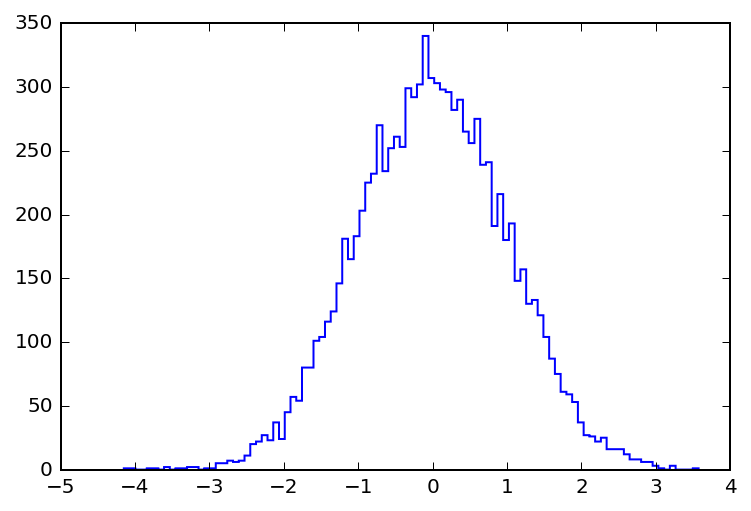

In [15]:
nspj = []
wait = True
for j in sim_phase_jobs:
    if wait or j.done():
        sim_phases.append(j.result())
    else:
        nspj.append(j)
sim_phase_jobs = nspj

print len(sim_phases), "/", len(sim_phases)+len(sim_phase_jobs)

sp = np.array(sim_phases)
print sp[:10]
print np.std(sp[:,0])
print np.average(sp[:,1]), np.std(sp[:,1])

plt.hist(sp[:,0]/sp[:,1], bins=int(np.sqrt(len(sim_phases))),
        histtype='step');

In [16]:
# Now let's apply a random horrible polarization miscalibration
noise_per_bin = 1e-2
def seed():
    # Need to re-seed the numpy random number generator in each forked worker process
    np.random.seed()
def simulate():
    shift = np.random.random()
    M = np.random.randn(4,4) # Whee!
    t_fake = (np.dot(M, tm.rotate_phase_iquv(t_pol, shift)) 
              + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1]))
    r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin)
    return tm.wrap(r.phase-shift), r.uncert
sim_phases = []
sim_phase_jobs = []
n_proc = multiprocessing.cpu_count()
ex = concurrent.futures.ProcessPoolExecutor(n_proc)
for i in range(2*n_proc):
    # double n_proc just in case
    ex.submit(seed)

In [17]:
for i in range(10000):
    sim_phase_jobs.append(ex.submit(simulate))

10000 / 10000
0.997736986708


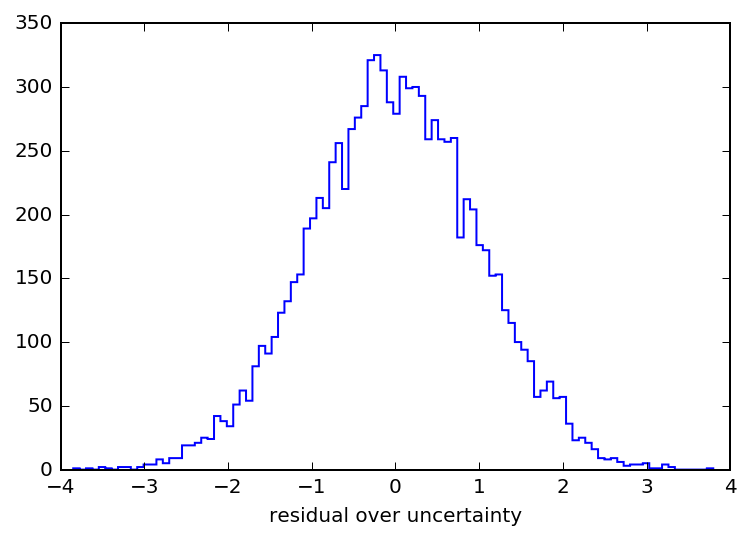

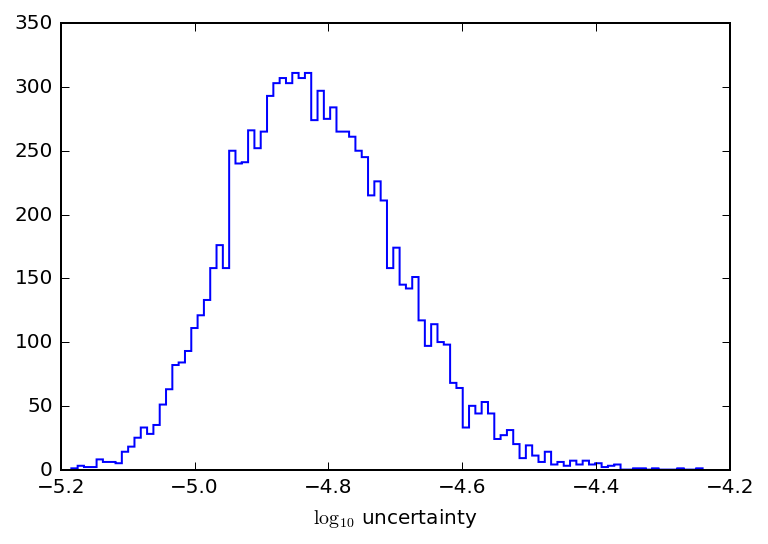

In [18]:
nspj = []
wait = True
for j in sim_phase_jobs:
    if wait or j.done():
        sim_phases.append(j.result())
    else:
        nspj.append(j)
sim_phase_jobs = nspj

print len(sim_phases), "/", len(sim_phases)+len(sim_phase_jobs)

sp = np.array(sim_phases)
print np.std(sp[:,0]/sp[:,1])

plt.hist(sp[:,0]/sp[:,1], bins=int(np.sqrt(len(sim_phases))),
        histtype='step');
plt.xlabel("residual over uncertainty")
plt.figure()
plt.hist(np.log10(sp[:,1]), bins=int(np.sqrt(len(sim_phases))),
        histtype='step');
plt.xlabel("$\log_{10}$ uncertainty")

All right, looks like the function works fine as long as its basic assumptions are satisfied - that the data is a transformed version of the profile with noise of known amplitude added. But what if the noise must be estimated from the data or the profile is not quite right? Or the noise is different in different polarization channels? In terms of XX, XY, YX, YY, we expect the noise to be the same in all four, but what happens in the transformation to Stokes parameters?

### Error estimation

0.300019430368 2.81709806101e-05 0.689729910008
2.81709806101e-05 2.8278552838e-05 2.88950578713e-05
(4, 1024)
-3.46167605365e-14


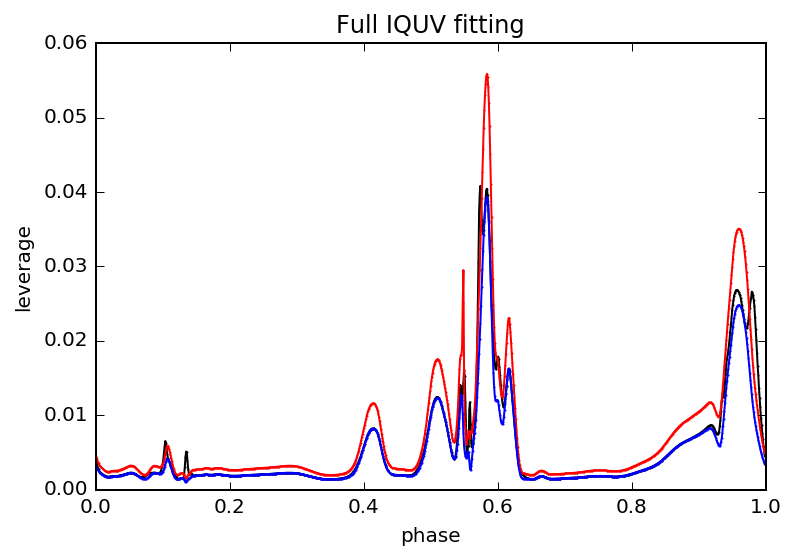

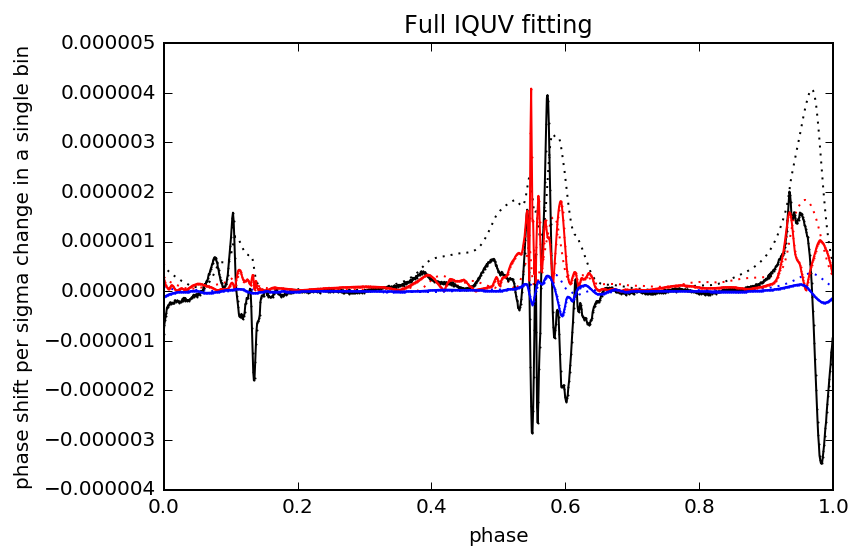

In [49]:
# How do the noise-estimation gizmos compare, in the best case?
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin)
print r.phase, r.uncert, (r.phase-shift)/r.uncert
print r.uncert, r.uncert_scaled, r.uncert_robust
tm.plot_iquv(r.leverage, linestyle="-")
plt.ylabel("leverage")
plt.title("Full IQUV fitting")
plt.figure()
print r.effect_on_phase.shape
tm.plot_iquv(r.template_in_data_space*np.amax(np.abs(r.effect_on_phase)), linestyle=":", marker="")
tm.plot_iquv(r.effect_on_phase, linestyle="-")
print np.sum(r.effect_on_phase*r.residuals)
plt.title("Full IQUV fitting")
plt.ylabel("phase shift per sigma change in a single bin")
plt.figure()


0.299981608297 3.26863895984e-05 -0.562671599364
3.26863895984e-05 0.000186136089337 3.08966140508e-05
(4, 1024)


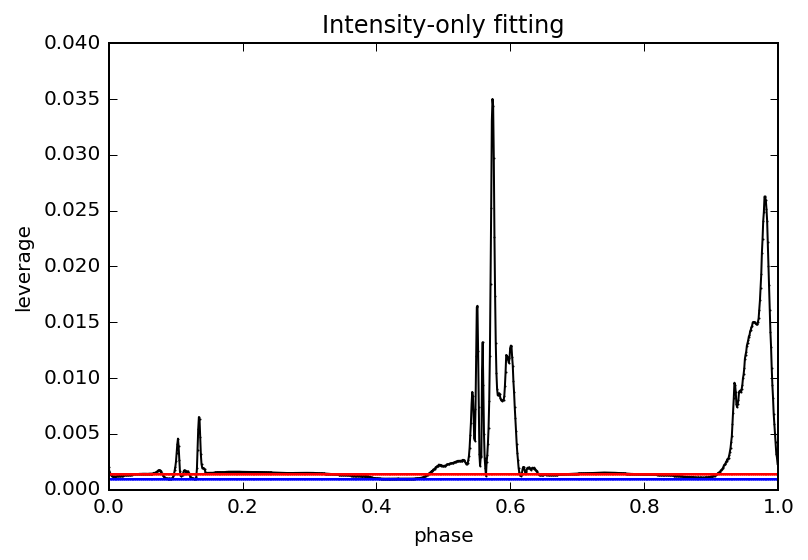

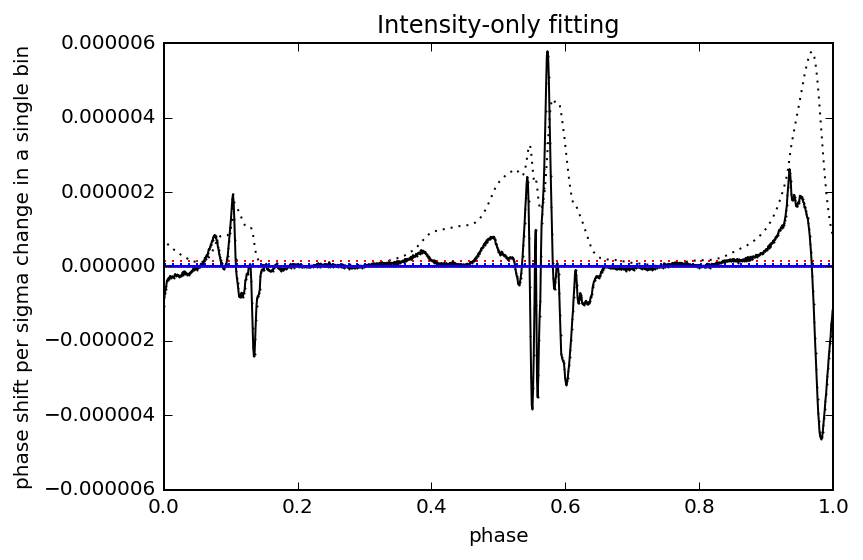

In [50]:
# How do the noise-estimation gizmos compare, in the best case?
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin, intensity_only=True)
print r.phase, r.uncert, (r.phase-shift)/r.uncert
print r.uncert, r.uncert_scaled, r.uncert_robust
tm.plot_iquv(r.leverage, linestyle="-")
plt.ylabel("leverage")
plt.title("Intensity-only fitting")
plt.figure()
print r.effect_on_phase.shape
tm.plot_iquv(r.template_in_data_space*np.amax(np.abs(r.effect_on_phase)), linestyle=":", marker="")
tm.plot_iquv(r.effect_on_phase, linestyle="-")
plt.ylabel("phase shift per sigma change in a single bin")
plt.title("Intensity-only fitting")
plt.figure()


In [51]:
# How much do the polarization channels help? Assuming perfect calibration.
noise_per_bin = 1e-2
shift = 0.3
t_fake_1 = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
t_fake_2 = t_fake_1.copy()
t_fake_2[1:] = 0
r_1 = tm.align_profile_polarization(t_pol, t_fake_1, global_search=shift, noise=noise_per_bin)
r_2 = tm.align_profile_polarization(t_pol, t_fake_2, global_search=shift, noise=noise_per_bin)
r_3 = tm.align_profile_polarization(t_pol, t_fake_1, global_search=shift, noise=noise_per_bin, intensity_only=True)
print r_1.uncert, r_2.uncert, r_2.uncert/r_1.uncert
print r_1.uncert, r_3.uncert, r_3.uncert/r_1.uncert


2.81787861306e-05 3.26680673079e-05 1.15931421448
2.81787861306e-05 3.26777385609e-05 1.1596574249


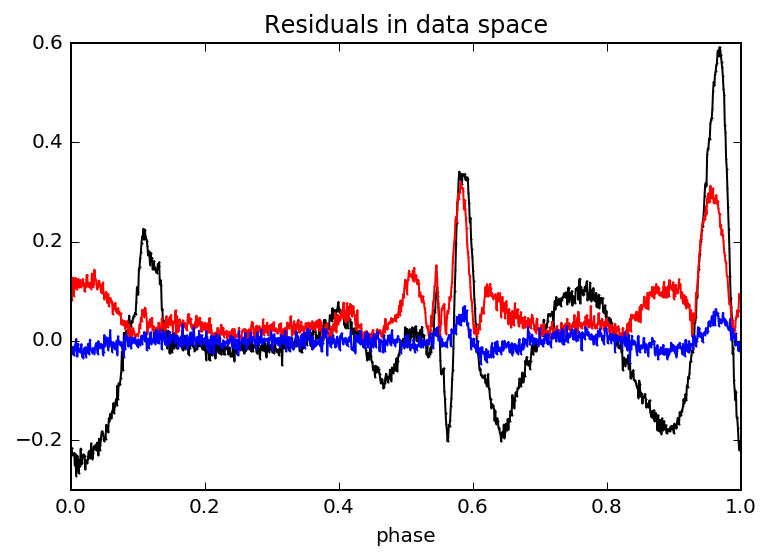

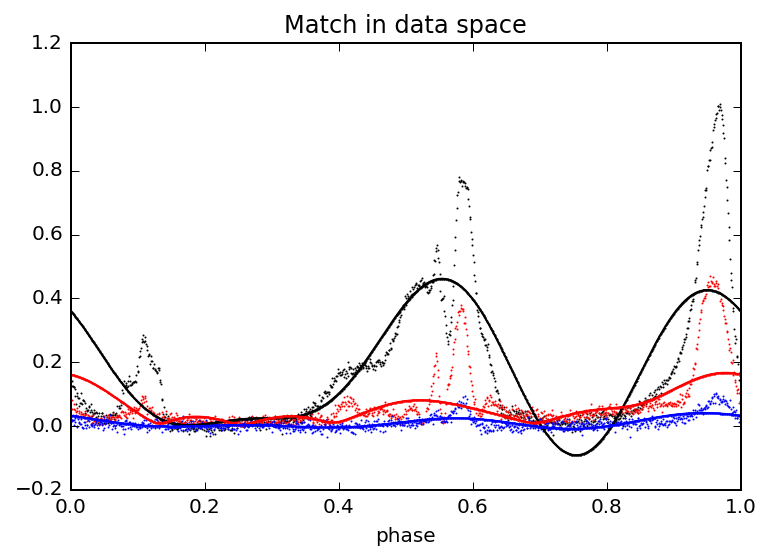

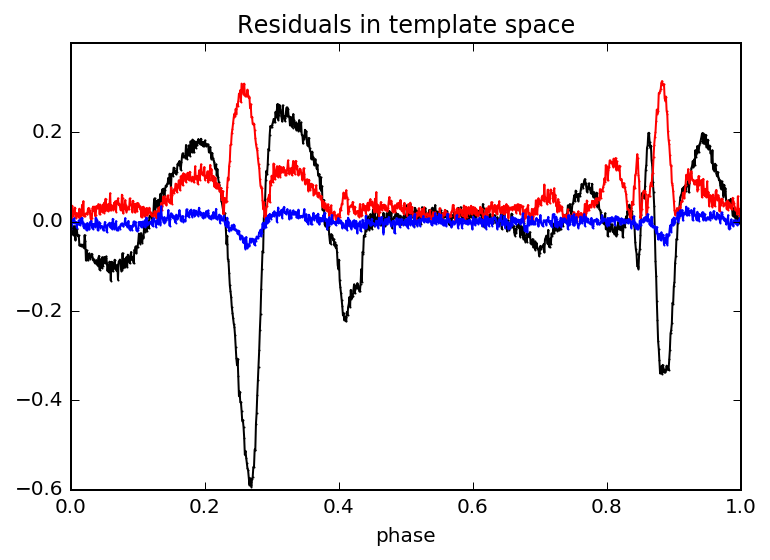

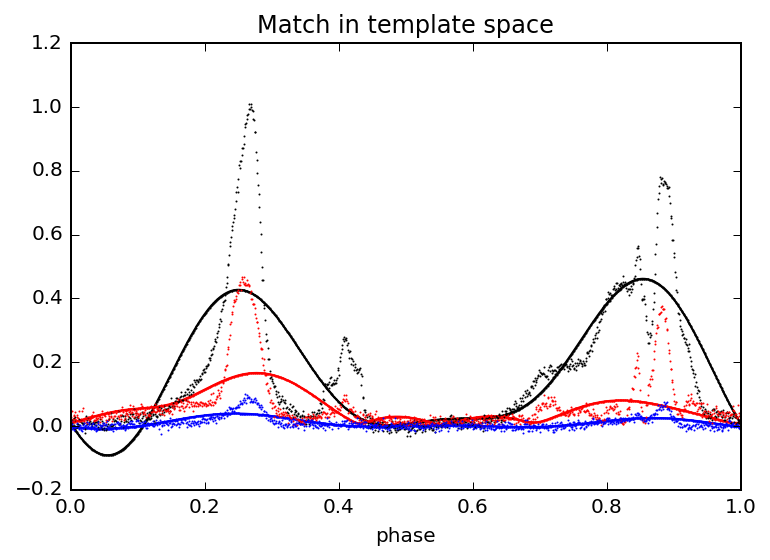

In [48]:
noise_per_bin = 1e-2
shift = 0.3
t_mangled_f = rfft(t_pol)
t_mangled_f[:,4:] = 0
t_mangled = irfft(t_mangled_f)
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])

r = tm.align_profile_polarization(t_mangled, t_fake, noise=noise_per_bin)

tm.plot_iquv(r.residuals, linestyle="-")
plt.title("Residuals in data space")

plt.figure()
tm.plot_iquv(t_fake)
tm.plot_iquv(r.template_in_data_space, linestyle="-")
plt.title("Match in data space")

plt.figure()
tm.plot_iquv(r.residuals_template, linestyle="-")
plt.title("Residuals in template space")

plt.figure()
tm.plot_iquv(t_mangled, linestyle="-")
tm.plot_iquv(r.data_in_template_space)
plt.title("Match in template space")


In [104]:
# Let's check the uncertainty
noise_per_bin = 1e-2
def seed():
    # Need to re-seed the numpy random number generator in each forked worker process
    np.random.seed()
def simulate():
    shift = np.random.random()
    t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
    r = tm.align_profile_polarization(t_mangled, t_fake, noise=noise_per_bin)
    return tm.wrap(r.phase-shift), r.uncert
sim_phases = []
sim_phase_jobs = []
n_proc = multiprocessing.cpu_count()
ex = concurrent.futures.ProcessPoolExecutor(n_proc)
for i in range(2*n_proc):
    # double n_proc just in case
    ex.submit(seed)

In [105]:
for i in range(1000):
    sim_phase_jobs.append(ex.submit(simulate))

In [112]:
nspj = []
wait = False
for j in sim_phase_jobs:
    if wait or j.done():
        sim_phases.append(j.result())
    else:
        nspj.append(j)
sim_phase_jobs = nspj

print len(sim_phases), "/", len(sim_phases)+len(sim_phase_jobs)

sp = np.array(sim_phases)
print sp[:,0].mean(), np.std((sp[:,0]-sp[:,0].mean())/sp[:,1])
print sp[:,1].mean()

29 / 1000
6.10506180873e-06 0.914616720614
0.000193886876219


Neat-o! The uncertainties are drastically worse with such a terrible template, but they are still calculated okay - at least, if we provide accurate per-bin noise estimates. We should expect the residual-based estimators to be completely terrible - that is, much too big, because while their covariance matrices are computed correctly, they are scaled by a hopelessly pessimistic error estimate.

In [114]:
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_mangled, t_fake, global_search=shift, noise=noise_per_bin)
print r.phase, r.uncert, (r.phase-shift)/r.uncert
print r.uncert, r.uncert_scaled, r.uncert_robust

0.300181035589 0.000193625315396 0.934978921838
0.000193625315396 0.0016094954957 0.00179102287788


### Estimating the noise

[0.009408605202909875 0.009474043055613515 0.010060491402345734
 0.009920987226657338]
0.01
[0.9408605202909875 0.9474043055613515 1.0060491402345735
 0.9920987226657337]


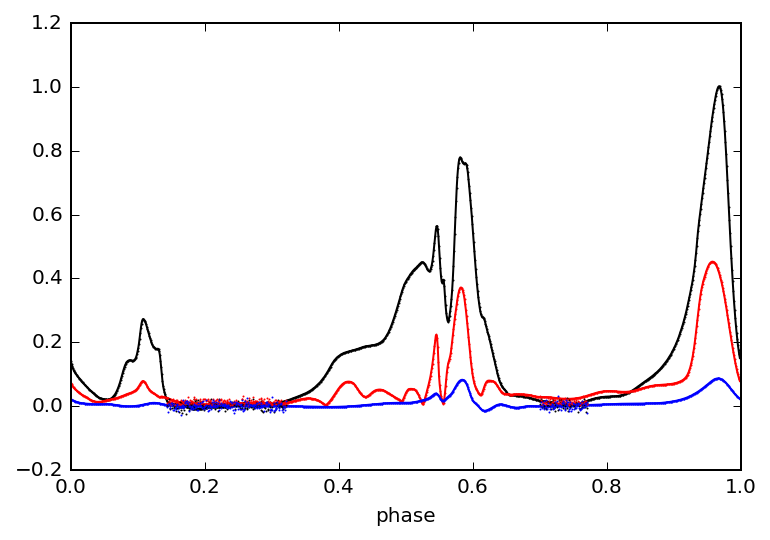

In [128]:
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake, global_search=shift, noise=noise_per_bin)
r_pol = tm.rotate_phase_iquv(t_pol, r.phase)
thresh = np.percentile(r_pol[0],25)
c = r_pol[0]<=thresh
res = np.ma.array(r.residuals)
res[:,~c] = np.ma.masked

tm.plot_iquv(r.template_in_data_space, linestyle="-")
tm.plot_iquv(res)
plt.figure()
noise = res.std(axis=-1)
print noise
print noise_per_bin
print noise/noise_per_bin

### Profiling

The slowest part is the global search; this can actually be slow enough to be a problem. So let's try to understand where it's slow.

In [77]:
%%prun
noise_per_bin = 1e-2
shift = 0.3
t_fake = tm.rotate_phase_iquv(t_pol, shift) + noise_per_bin*np.random.randn(t_pol.shape[0],t_pol.shape[1])
r = tm.align_profile_polarization(t_pol, t_fake)


### Testing with real data

Of course we don't have known amounts of noise in other profiles, but we do, potentially at least, have real differences in profile shape. Still we can look at several things:

* What do noise levels look like? In particular, do we have equal noise in the four Stokes parameters? If not, or at least, if they're substantially different, we may want to reweight the fitting procedure.

* Using a different smoothed profile plus synthetic noise: does noise estimation turn out okay? Are errors computed reasonably?

* How do real levels of miscalibration affect the fit results? They shouldn't, really, since I've been testing with arbitrary and terrible transformations, but real miscalibrations will all lie near the Jones possibilities, and maybe that subspace gives more trouble.

(4, 1024)
(4, 2048)


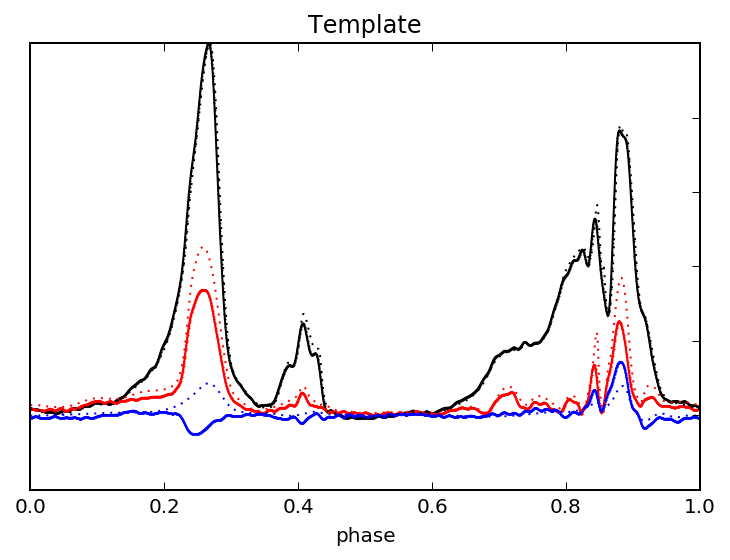

In [3]:
template_other = "template-work/56736.85_AO_1400.profile.psrsmooth"
T2 = psrchive.Archive_load(template_other)
T2.convert_state('Stokes')
T2.dedisperse()
T2.remove_baseline()
t2_values = T2.get_data()[0,0,0,:]
t2_pol = T2.get_data()[0,:,0,:]
t2_pol /= np.amax(t2_values)
t2_values /= np.amax(t2_values)
# shift fundamental to zero phase
a = np.angle(np.fft.fft(t2_values)[1])/(2*np.pi)
t2_values = pipe.rotate_phase(t2_values, -a) 
t2_pol = np.array([pipe.rotate_phase(p, -a) for p in t2_pol])
t2_phases = np.linspace(0,1,len(t2_values),endpoint=False)
tm.plot_iquv(t2_pol, linestyle="-")
tm.plot_iquv(t_pol, linestyle=":", marker="")
plt.title("Template")
plt.xlabel("phase")
plt.gca().tick_params("y", left="off", labelleft="off")
print t_pol.shape
print t2_pol.shape

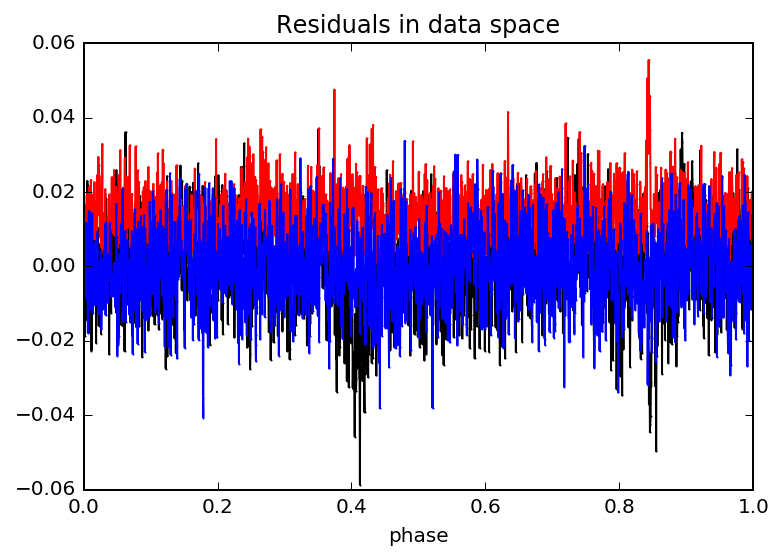

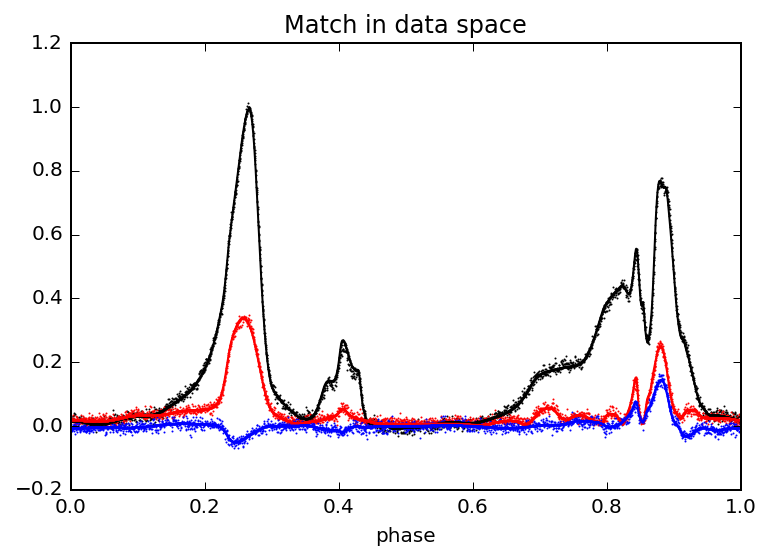

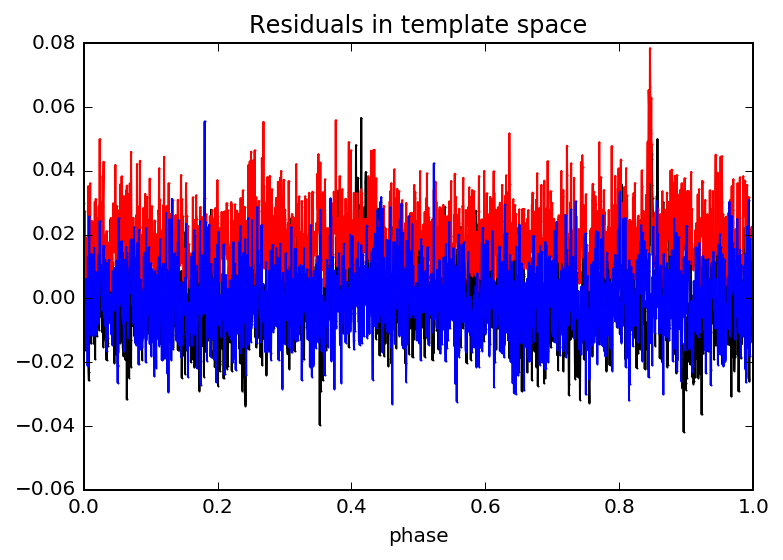

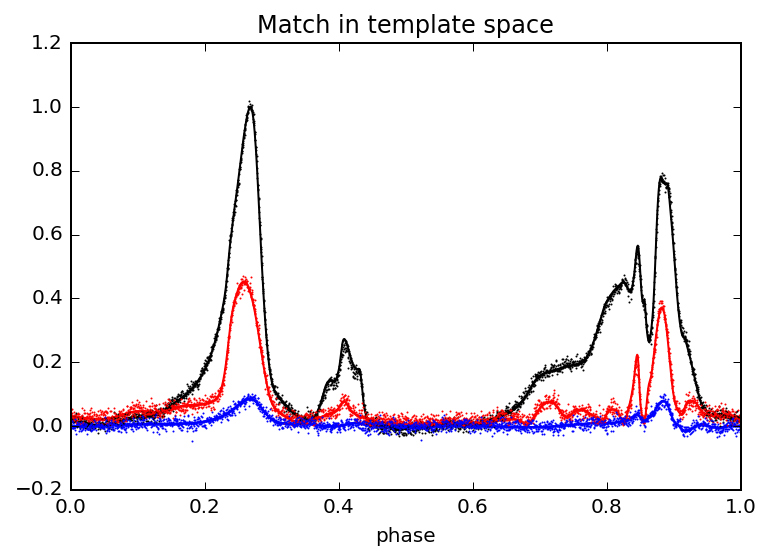

In [5]:
noise_per_bin = 1e-2
shift = 0.
t_fake = tm.rotate_phase_iquv(t2_pol, shift) + noise_per_bin*np.random.randn(t2_pol.shape[0],t2_pol.shape[1])

r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)

tm.plot_iquv(r.residuals, linestyle="-")
plt.title("Residuals in data space")

plt.figure()
tm.plot_iquv(t_fake)
tm.plot_iquv(r.template_in_data_space, linestyle="-")
plt.title("Match in data space")

plt.figure()
tm.plot_iquv(r.residuals_template, linestyle="-")
plt.title("Residuals in template space")

plt.figure()
tm.plot_iquv(t_pol, linestyle="-")
tm.plot_iquv(r.data_in_template_space)
plt.title("Match in template space")


In [16]:
try:
    ex.shutdown(wait=False)
    del ex
    for j in sim_phase_jobs:
        j.cancel()
except NameError:
    pass
# Let's check the uncertainty
noise_per_bin = 1e-2
def seed():
    # Need to re-seed the numpy random number generator in each forked worker process
    np.random.seed()
def simulate():
    shift = np.random.random()
    t_fake = tm.rotate_phase_iquv(t2_pol, shift) + noise_per_bin*np.random.randn(t2_pol.shape[0],t2_pol.shape[1])
    r = tm.align_profile_polarization(t_pol, t_fake, noise=noise_per_bin)
    return tm.wrap(r.phase-shift), r.uncert
sim_phases = []
sim_phase_jobs = []
n_proc = multiprocessing.cpu_count()//2-1
ex = concurrent.futures.ProcessPoolExecutor(n_proc)
for i in range(2*n_proc):
    # double n_proc just in case
    ex.submit(seed)

In [17]:
for i in range(100):
    sim_phase_jobs.append(ex.submit(simulate))

In [29]:
nspj = []
wait = False
for j in sim_phase_jobs:
    if wait or j.done():
        sim_phases.append(j.result())
    else:
        nspj.append(j)
sim_phase_jobs = nspj

print len(sim_phases), "/", len(sim_phases)+len(sim_phase_jobs)

sp = np.array(sim_phases)
print sp[:,0].mean(), np.std((sp[:,0]-sp[:,0].mean())/sp[:,1])
print sp[:,1].mean()

KeyboardInterrupt: 

data/obs/56117.50_AO_1400 [ 0.00072061  0.00073019  0.00074031  0.00067301]
data/obs/56494.49_GBT_1400 [ 0.00031182  0.00030529  0.00031116  0.00032303]
data/obs/56496.15_WSRT_1400 [ 0.00493211  0.00434767  0.00469071  0.00426175]
data/obs/56207.39_GBT_1400 [ 0.00029221  0.0002839   0.00025233  0.00028256]
data/obs/56214.26_GBT_1400 [ 0.00031806  0.00032774  0.00031159  0.00031802]
data/obs/56477.53_AO_1400 [ 0.00130353  0.00128323  0.00093996  0.00080839]
data/obs/56412.76_GBT_1400 [  6.38080061e-05   6.06412299e-05   6.91127261e-05   6.30858185e-05]


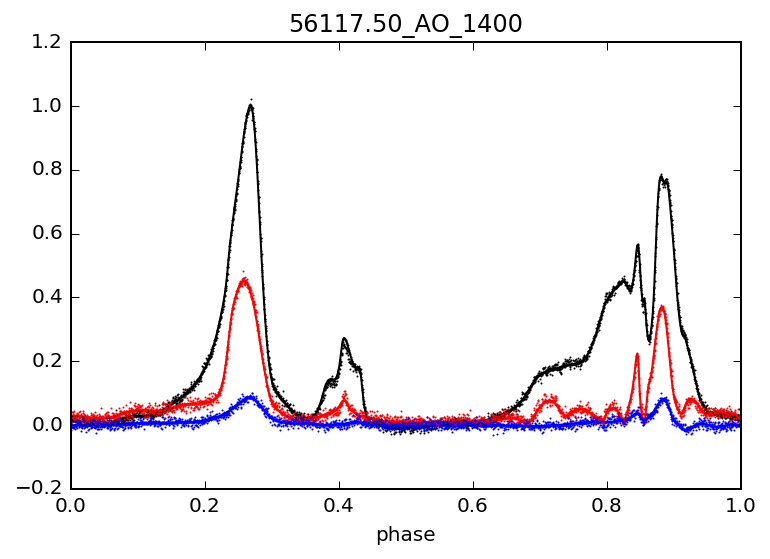

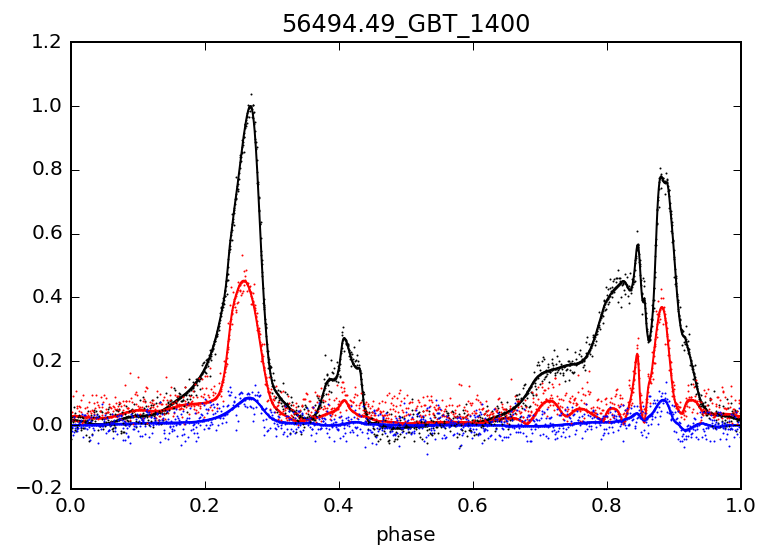

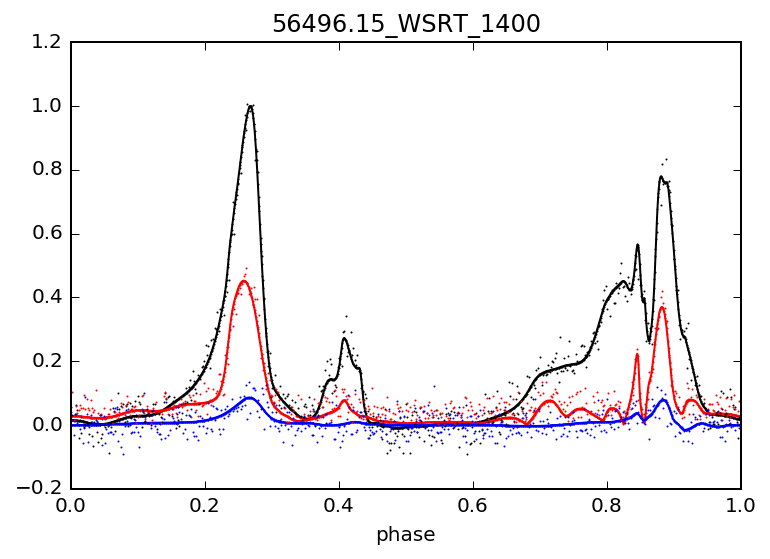

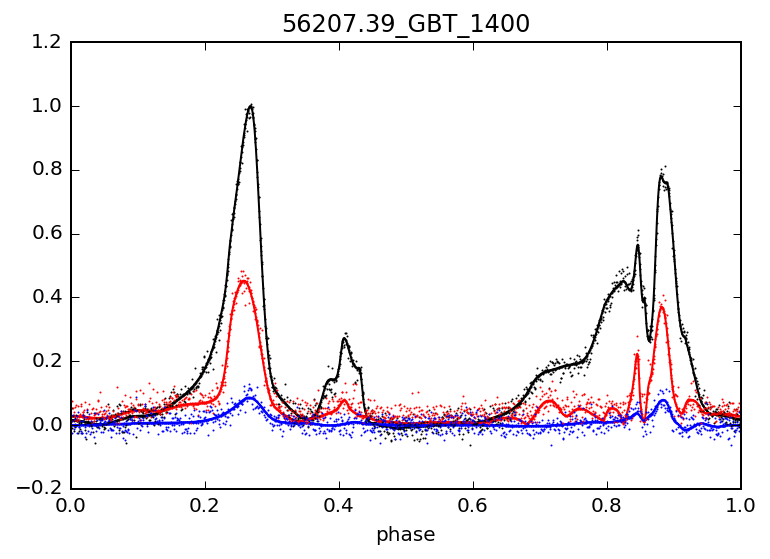

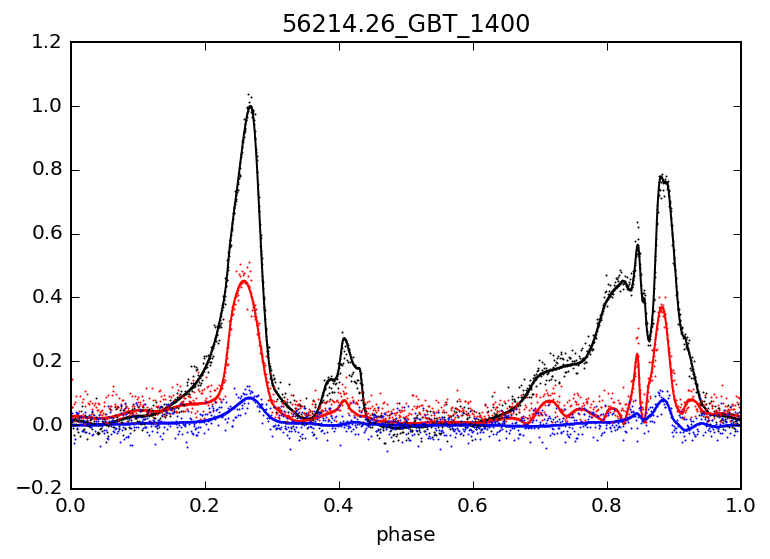

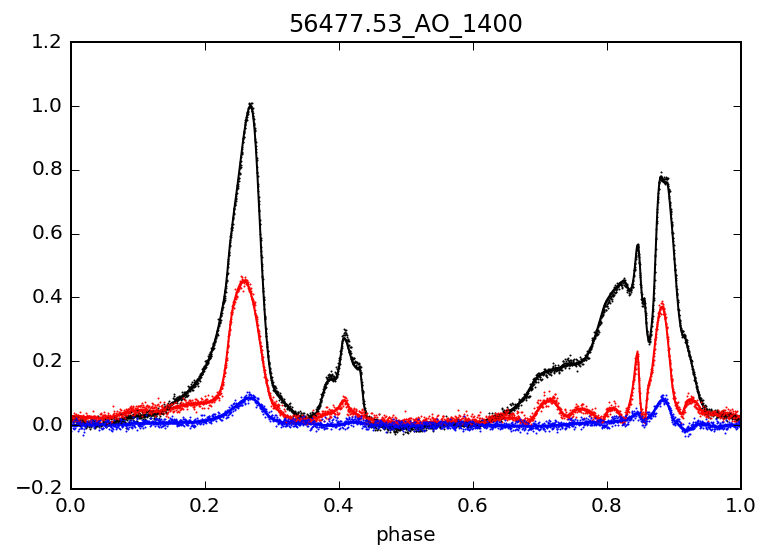

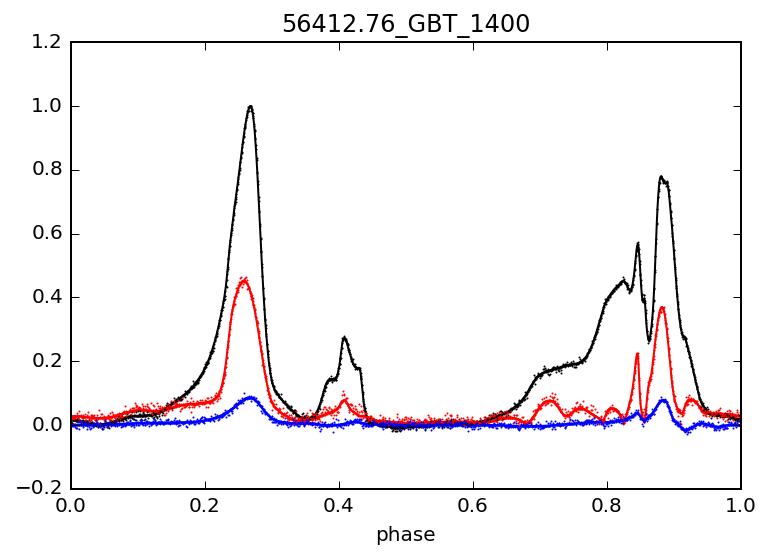

In [31]:
processing_name = "wideband"
for o in ["data/obs/56117.50_AO_1400",
            "data/obs/56494.49_GBT_1400",
            "data/obs/56070.64_AO_430",
            "data/obs/56479.20_WSRT_350",
            "data/obs/56496.15_WSRT_1400",
            "data/obs/56207.39_GBT_1400",
           "data/obs/56214.26_GBT_1400",
           "data/obs/56477.53_AO_1400",
           "data/obs/56412.76_GBT_1400"]:
    s = glob(join(o,processing_name,"scrunch_*.ar"))
    if not s:
        continue
    F = psrchive.Archive_load(s[0])
    F.tscrunch()
    F.fscrunch()
    try:
        F.convert_state("Stokes")
        obs_data = F.get_data()[0,:,0,:]
    except IndexError:
        obs_data_i = F.get_data()[0,0,0,:]
        obs_data = np.zeros((4,len(obs_data_i)))
        obs_data[0] = obs_data_i
    r = tm.align_profile_polarization(t_pol, obs_data)
    plt.figure()
    plt.title(os.path.split(o)[-1])
    tm.plot_iquv(t_pol, linestyle="-")
    tm.plot_iquv(r.data_in_template_space)
    print o, r.noises

### Actual TOA generation

In [3]:
#obs = "data/obs/56412.76_GBT_1400"
#processing_name = "singlefrequency"
obs = "data/obs/56494.49_GBT_1400"
processing_name = "onescintle"
scr, = glob(join(obs,processing_name,"scrunch_*.ar"))
F = psrchive.Archive_load(scr)

In [4]:
meta = dict(observation=obs, 
            processing_name=processing_name, 
            template_path=template, 
            mjd=F.start_time().in_days())
summary = dict(meta=meta)
pipe.prepare_toa_info(summary)

In [26]:
tm_toa_info = tm.generate_toa_info(t_pol, scr)

DEBUG:root:subint 0 of 2
DEBUG:root:chan 8 of 128
DEBUG:root:chan 9 of 128
DEBUG:root:chan 10 of 128
DEBUG:root:chan 11 of 128
DEBUG:root:chan 12 of 128
DEBUG:root:chan 13 of 128
DEBUG:root:chan 14 of 128
DEBUG:root:chan 15 of 128
DEBUG:root:chan 16 of 128
DEBUG:root:chan 17 of 128
DEBUG:root:chan 18 of 128
DEBUG:root:chan 19 of 128
DEBUG:root:chan 20 of 128
DEBUG:root:chan 21 of 128
DEBUG:root:chan 22 of 128
DEBUG:root:chan 23 of 128
DEBUG:root:chan 26 of 128
DEBUG:root:chan 27 of 128
DEBUG:root:chan 28 of 128
DEBUG:root:chan 29 of 128
DEBUG:root:chan 32 of 128
DEBUG:root:chan 33 of 128
DEBUG:root:chan 34 of 128
DEBUG:root:chan 35 of 128
DEBUG:root:chan 36 of 128
DEBUG:root:chan 37 of 128
DEBUG:root:chan 38 of 128
DEBUG:root:chan 39 of 128
DEBUG:root:chan 40 of 128
DEBUG:root:chan 41 of 128
DEBUG:root:chan 42 of 128
DEBUG:root:chan 43 of 128
DEBUG:root:chan 45 of 128
DEBUG:root:chan 46 of 128
DEBUG:root:chan 47 of 128
DEBUG:root:chan 48 of 128
DEBUG:root:chan 49 of 128
DEBUG:root:chan

In [27]:
pat_toa_info = summary["toa_info"]
tm_toa_info[0], pat_toa_info[0]

({'file': 'data/obs/56494.49_GBT_1400/onescintle/scrunch_0000.ar',
  'flags': {'P': 0.002732301836043067,
   'bw': 6.25,
   'chan': 8,
   'dt': 9.6593107824652836e-09,
   'epoch_mjd': 56494.48865065865856,
   'nbin': 1024,
   'phase': 0.30544372535855002,
   'reduced_chi2': 1.0042486850620111,
   'snr': 859.00675916519447,
   'subint': 0,
   'tsubint': 655.9680000000005,
   'uncert': 0.00098281647029574383,
   'uncert_scaled': 0.00098490209617991512,
   'weighted_frequency': 1510.6408344515858},
  'freq': 1153.90625,
  'mjd': 56494.488650648999251,
  'mjd_string': '56494.48865064899925081399',
  'tel': 'gbt',
  'uncert': 2.6853512462824276},
 {'file': 'data/obs/56494.49_GBT_1400/onescintle/scrunch_0000.ar',
  'flags': {'be': 'GUPPI',
   'bw': '6.25',
   'f': 'Rcvr1_2_GUPPI',
   'fe': 'Rcvr1_2',
   'nbin': '1024',
   'nch': '4',
   'tmplt': 'template-work/56412.76_GBT_1400.rmset.scrunch.sm',
   'tobs': '655.97'},
  'freq': 1153.90625,
  'mjd': 56494.48865066548,
  'mjd_string': '56494.4

In [28]:
P = tm_toa_info[0]['flags']['P']
(tm_toa_info[0]['mjd']-pat_toa_info[0]['mjd'])*86400/P

-0.52115660334943492664

<Container object of 3 artists>

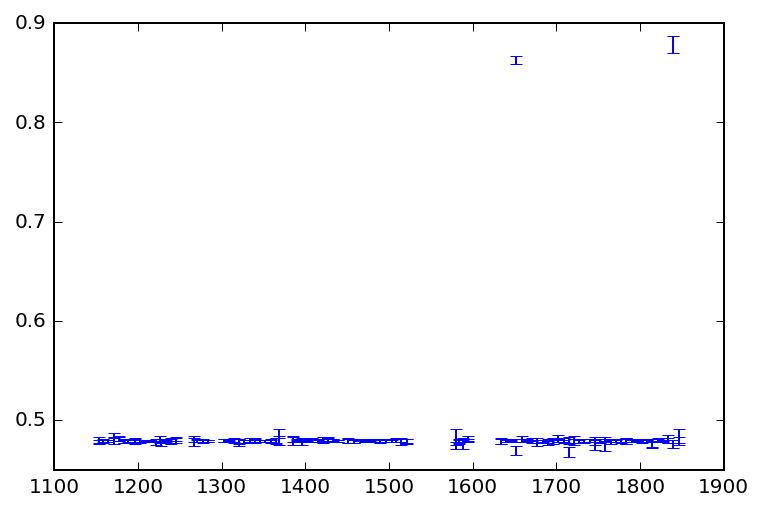

In [31]:
dphases = []
uncerts = []
freqs = []
for (t,p) in zip(tm_toa_info, pat_toa_info):
    assert np.abs(t["freq"]-p["freq"])<1e-2, "%f != %f" % (t['freq'], p['freq'])
    freqs.append(t["freq"])
    P = t['flags']['P']
    dt = tm.wrap(t['flags']['phase'])*P/86400.
    mjd = t['flags']['epoch_mjd']-dt
    mjd = t['mjd']
    dp = tm.wrap((mjd-np.float128(p['mjd_string']))*86400/P, 0.45)
    dphases.append(dp)
    uncerts.append(np.hypot(t['uncert'],p['uncert'])*1e-6/P)
    
plt.errorbar(freqs, dphases, uncerts, linestyle="")

In [36]:
weirdos = np.where(np.abs(np.array(dphases)-0.45)>0.2)[0]

0.113488444347 0.110040665652
0.0774090757839 0.0795780352025


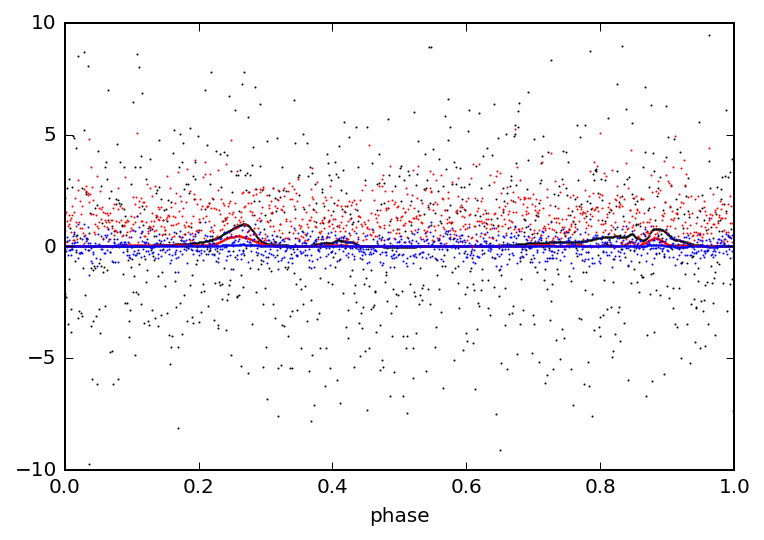

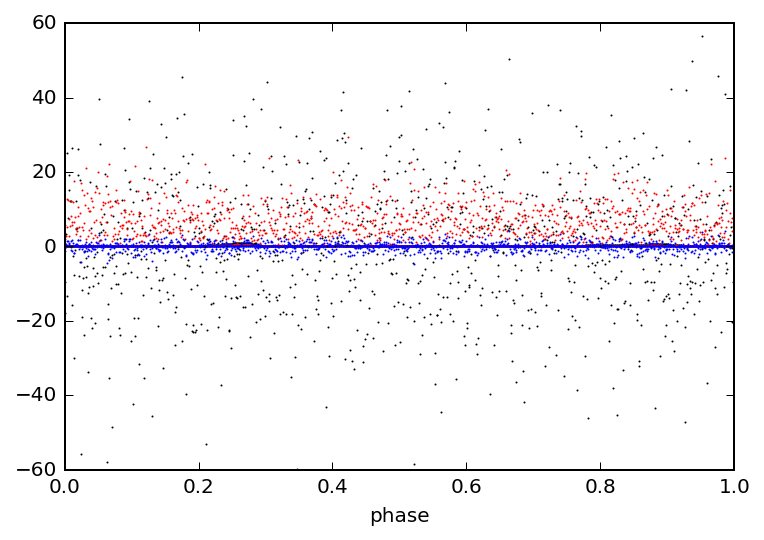

In [43]:
for w in weirdos:
    t = tm_toa_info[w]
    subint = t['flags']['subint']
    chan = t['flags']['chan']
    
    plt.figure()
    prof = F.get_data()[subint,:,chan,:]
    r = tm.align_profile_polarization(t_pol, prof)
    tm.plot_iquv(t_pol,linestyle="")
    tm.plot_iquv(r.data_in_template_space,linestyle="")
    print r.snr, r.snr_residuals